# The Schilling distribution in CorMap

András Wacha

27th Oct. 2016.

# Initialization

In [1]:
%pylab inline
%load_ext cython
import time
import ipy_table
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Definition of the algorithms

## Algorithms according Schilling's paper
I have implemented these in Cython for the sake of speed

In [2]:
%%cython
cimport numpy as np
import numpy as np
np.import_array()

cdef Py_ssize_t A_(Py_ssize_t n, Py_ssize_t x):
    """Calculate A_n(x) as per Schilling's original paper"""
    cdef Py_ssize_t j
    cdef Py_ssize_t val=0
    if n<=x:
        return 2**n
    else:
        for j in range(0, x+1):
            val += A_(n-1-j, x)
        return val
    
def A(n, x):
    """Python interface for A_(n, x)"""
    return A_(n,x)
    
def Amatrix(Py_ssize_t N):
    """Calculate an NxN matrix of the Schilling distribution
    
    The elements A[n, x] are the number of possible outcomes of an n-sequence of
    independent coin-tosses where the maximum length of consecutive heads is
    _not_larger_than x."""
    cdef np.ndarray[np.uint64_t, ndim=2] result
    cdef Py_ssize_t n,x
    result = np.empty((N, N), np.uint64)
    for x in range(N):
        for n in range(0, x+1):
            result[n,x]=(2**n)
        for n in range(x+1,N):
            result[n, x]=result[n-1-x:n,x].sum()
    return result
            
def amatrix(Py_ssize_t N):
    """Calculate an NxN matrix of the Schilling distribution
    
    The elements a[n, x] are the number of possible outcomes of an n-sequence of
    independent coin-tosses where the maximum length of consecutive heads is
    _exactly_ x. Thus a[n, x] = A[n, x] - A[n, x-1]"""
    cdef np.ndarray[np.uint64_t, ndim=2] result
    cdef Py_ssize_t n,x
    cdef Py_ssize_t val
    result = np.zeros((N, N), np.uint64)
    result[:,0] = 1 # a_n(x=0) = 1
    for n in range(N):
        result[n,n] = 1 #a_n(x=n) = 1
        # a_n(x>n) = 0
        for x in range(1, n):
            result[n,x] = result[n-1-x:n,x].sum() + result[n-1-x,:x].sum()
    return result

def pmatrix(Py_ssize_t N):
    """Calculate an NxN matrix of the Schilling distribution.
    
    The elements p[n, x] of the resulting matrix are the probabilities that
    the length of the longest head-run in a sequence of n independent tosses
    of a fair coin is exactly x.
    
    It holds that p[n, x] = a[n, x] / 2 ** n = (A[n, x] - A[n, x-1]) / 2 ** n
    
    Note that the probability that the length of the longest run 
    (no matter if head or tail) in a sequence of n independent 
    tosses of a fair coin is _exactly_ x is p[n-1, x-1].
    """
    cdef np.ndarray[np.double_t, ndim=2] result
    cdef Py_ssize_t n,x,j
    cdef double val
    result = np.zeros((N, N), np.double)
    for n in range(N):
        result[n, 0] = 2.0**(-n)
        result[n, n] = 2.0**(-n) #p_n(x=n) = 1/2**n
        # p_n(x>n) = 0
        for x in range(1, n):
            val=0
            for j in range(n-1-x,n):
                val+=2.0**(j-n)*result[j,x]
            for j in range(0, x):
                val += 2.0**(-x-1)*result[n-1-x,j]
            result[n,x] = val
    return result
    

## The cormap_pval algorithm from Daniel Franke, EMBL Hamburg

In [3]:
def cormap_pval(n, x):
    """Cormap P-value algorithm, giving the probability that from
    n coin-tosses the longest continuous sequence of either heads
    or tails is _not_shorter_ than x.
    
    Python version of the original Fortran90 code of Daniel Franke"""
    dbl_max_exponent=np.finfo(np.double).maxexp-1
    P=np.zeros(dbl_max_exponent)
    if x <=1:
        pval = 1
    elif x>n:
        pval = 0
    elif x>dbl_max_exponent:
        pval = 0
    elif x==n:
        pval = 2.0**(1-x)
    else:
        half_pow_x = 2**(-x)
        P[1:x] = 0
        i_x = 0
        P[i_x]=2*half_pow_x
        for i in range(x+1, n+1):
            im1_x = i_x #  == (i-1) % x
            i_x = i % x
            P[i_x] = P[im1_x] + half_pow_x * (1-P[i_x])
        pval = P[i_x]
    return pval

# Validation of the Cython-algorithms

## Check 1
Amatrix() returns the same values as Schilling's recursive formula for A_n(x)

In [4]:
N=20
# Calculate the matrix for A using the slow method
A_slow = np.empty((N,N), np.uint64)
for n in range(N):
    for x in range(N):
        A_slow[n,x]=A(n,x)
A_fast = Amatrix(N)
print('The two matrices are the same:',(np.abs(A_slow - A_fast)).sum()==0)

The two matrices are the same: True


## Check 2
$A_n(x) = \sum_{j=0}^{x}a_n(j)$

In [5]:
N=50
a=amatrix(N)
A_fast=Amatrix(N)
A_constructed=np.empty((N,N), np.uint64)
for x in range(N):
    A_constructed[:, x]=a[:,:x+1].sum(axis=1)
print('The two matrices are the same:',(np.abs(A_fast - A_constructed).sum()==0))

The two matrices are the same: True


## Check 3
$p_n(x) = 2^{-n}a_n(x)$

In [6]:
N=50
p=pmatrix(N)
a=amatrix(N)
p_from_a=np.empty((N,N), np.double)
for n in range(N):
    p_from_a[n, :] = a[n, :]/2**n
print('The two matrices are the same:',(np.abs(p - p_from_a).sum()==0))

The two matrices are the same: True


## Check 4
Well-known special cases

### 1 toss
2 possible outcomes: H, T
<table>
    <tr><th>Max length</th><th>Outcomes</th><th>p</th></tr>
    <tr><td>1</td><td>2</td><td>1</td></tr>
</table>

### 2 tosses
4 possible outcomes: HH, HT, TH, TT
<table>
    <tr><th>Max length</th><th>Outcomes</th><th>p</th></tr>
    <tr><td>1</td><td>2</td><td>0.5</td></tr>
    <tr><td>2</td><td>2</td><td>0.5</td></tr>
</table>

### 3 tosses
8 possible outcomes: HHT, HTT, THT, TTT, HHH, HTH, THH, TTH
<table>
    <tr><th>Max length</th><th>Outcomes</th><th>p</th></tr>
    <tr><td>1</td><td>2</td><td>0.25</td></tr>
    <tr><td>2</td><td>4</td><td>0.5</td></tr>
    <tr><td>2</td><td>2</td><td>0.25</td></tr>
</table>

### 4 tosses
16 possible outcomes:
<table>
       <tr><th>Outcome</th><th>Longest sequence length</th></tr>
       <tr><td>HHTH</td><td>2</td></tr>
       <tr><td>HTTH</td><td>2</td></tr>
       <tr><td>THTH</td><td>1</td></tr>
       <tr><td>TTTH</td><td>3</td></tr>
       <tr><td>HHHH</td><td>4</td></tr>
       <tr><td>HTHH</td><td>2</td></tr>
       <tr><td>THHH</td><td>3</td></tr>
       <tr><td>TTHH</td><td>2</td></tr>
       <tr><td>HHTT</td><td>2</td></tr>
       <tr><td>HTTT</td><td>3</td></tr>
       <tr><td>THTT</td><td>2</td></tr>
       <tr><td>TTTT</td><td>4</td></tr>
       <tr><td>HHHT</td><td>3</td></tr>
       <tr><td>HTHT</td><td>1</td></tr>
       <tr><td>THHT</td><td>2</td></tr> 
       <tr><td>TTHT</td><td>2</td></tr>
</table>
<table>
    <tr><th>Max length</th><th>Outcomes</th><th>p</th></tr>
    <tr><td>1</td><td>2</td><td>0.125</td></tr>
    <tr><td>2</td><td>8</td><td>0.5</td></tr>
    <tr><td>3</td><td>4</td><td>0.25</td></tr>
    <tr><td>4</td><td>2</td><td>0.125</td></tr>
</table>


In [7]:
p=pmatrix(50)
for n in range(1,5):
    print('{} toss(es):'.format(n))
    for x in range(1,n+1):
        print('  p_{}({}) = {}'.format(n,x,p[n-1,x-1]))

1 toss(es):
  p_1(1) = 1.0
2 toss(es):
  p_2(1) = 0.5
  p_2(2) = 0.5
3 toss(es):
  p_3(1) = 0.25
  p_3(2) = 0.5
  p_3(3) = 0.25
4 toss(es):
  p_4(1) = 0.125
  p_4(2) = 0.5
  p_4(3) = 0.25
  p_4(4) = 0.125


# Estimate the execution time

/home/labuser/miniconda3/envs/credolib/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


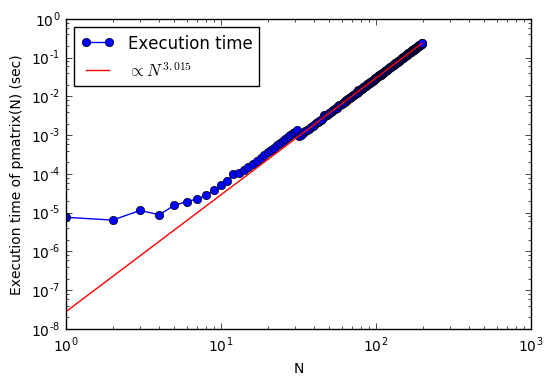

In [8]:
Nmax=200
times = np.empty(Nmax)
for i in range(Nmax):
    t0=time.monotonic()
    p=pmatrix(i)
    times[i]=time.monotonic()-t0
plt.loglog(np.arange(Nmax),times,'o-',label='Execution time')
plt.xlabel('N')
plt.ylabel('Execution time of pmatrix(N) (sec)')
x=np.arange(Nmax)
a,b=np.polyfit(np.log(x[x>100]), np.log(times[x>100]),1)
plt.loglog(x,np.exp(np.log(x)*a+b),'r-', label='$\\propto N^{%.3f}$' % a)
plt.legend(loc='best')

# Some visualization

Most probable maximum head-run length: 4


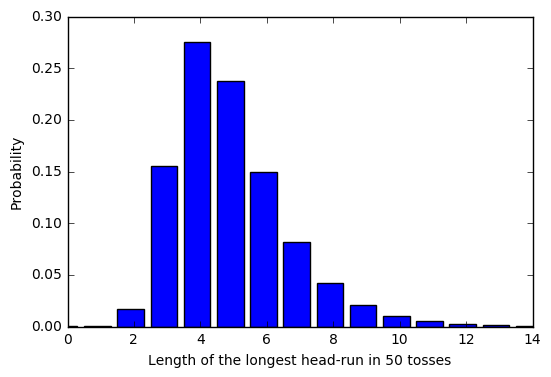

In [9]:
N=50
p=pmatrix(N+1)
bar(left=np.arange(p.shape[1])-0.5,height=p[N,:])
plt.axis(xmin=0,xmax=14)
plt.xlabel('Length of the longest head-run in {} tosses'.format(N))
plt.ylabel('Probability')
print('Most probable maximum head-run length:',p[N,:].argmax())

# Large numbers

Calculate a large p matrix (takes some time, see above) for use of later computations

In [10]:
N=2050
print('Calculating {0}x{0} p-matrix...', flush=True)
t0=time.monotonic()
p=pmatrix(N)
t=time.monotonic()-t0
print('Done in {} seconds'.format(t))
np.savez('cointoss_p.npz',p=p)

Calculating {0}x{0} p-matrix...
Done in 602.0220224929508 seconds


Visualize the matrix: 

/home/labuser/miniconda3/envs/credolib/lib/python3.5/site-packages/matplotlib/colors.py:1039: RuntimeWarning: overflow encountered in double_scalars
  return vmin * ma.power((vmax / vmin), val)


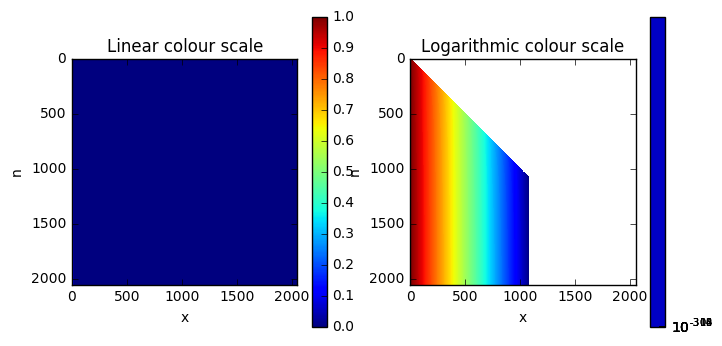

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(p,norm=matplotlib.colors.Normalize(),interpolation='nearest')
plt.xlabel('x')
plt.ylabel('n')
plt.title('Linear colour scale')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(p,norm=matplotlib.colors.LogNorm(), interpolation='nearest')
plt.xlabel('x')
plt.ylabel('n')
plt.title('Logarithmic colour scale')
plt.colorbar()

# Compare with the algorithm in CorMap

Note that in CorMap, the p-value is the probability that the longest continuous sequence of either heads or tails in $n$ coin-tosses is **not shorter** than $x$, while our ``pmatrix()`` gives the probability that it is **exactly** $x$ long. The desired quantity is obtained from the ``pmatrix()`` approach as $\sum_{j \ge(x-1)} p_n(j)$.

In [15]:
table =[['n', 'x', 'p (D. Franke)', 'p (A. Wacha)']]
for n, x in [(449,137),(449,10),(2039,338),(2039,18),(200,11),(10,2), (1,0), (1,1), (2,0), (2,1), (2,2), (3,0), (3,1), (3,2), (3,3), (4,0), (4,1), (4,2), (4,3), (4,4)]:
    table.append([n,x,cormap_pval(n,x), p[n-1,max(0,x-1):].sum()])
    
tab=ipy_table.IpyTable(table)
tab.apply_theme('basic')
display(tab)

n,x,p (D. Franke),p (A. Wacha)
449,137,1.8022716121e-39,1.8022716121e-39
449,10,0.352523622439,0.352523622439
2039,338,3.04141801149e-99,3.04141801149e-99
2039,18,0.00768794102072,0.00768794102072
200,11,0.0894719050962,0.0894719050962
10,2,0.998046875,0.998046875
1,0,1,1.0
1,1,1,1.0
2,0,1,1.0
2,1,1,1.0
